# Gunpla Datasets

We will use Dalong's Gunpla Review(http://www.dalong.net/) as train/test set, the images are shuffled and 70% of them will be training set, the rest will be test set.
For cross validation, we'll use the data from https://acg.78dm.net/ct/3272.html. Dalong have much more images than 78dm.

As a result, the traning/test will have same distribution, but cross vaidation set's distrubution is diferrent. It's not the best way to organize the data, but it's easier start with.

> Note: Gunpla comes with many *grades*: HG, MG, RG, PG, etc. For simplicity, we'll start with [RG](http://dalong.net/reviews/rg.htm) since it have fewer models (37 as of this writting at 10/29/2022).

## Setup the request timeout and retries

In [165]:
import requests
from requests.adapters import HTTPAdapter

TIMEOUT=3
MAX_RETRIES=3


session = requests.Session()
session.mount('http://', HTTPAdapter(max_retries=MAX_RETRIES))
session.mount('https://', HTTPAdapter(max_retries=MAX_RETRIES))


def session_get(url: str, **kwargs):
    return session.get(url, timeout=TIMEOUT, **kwargs)

# Fetching the training/test dataset from dalong.net

In [166]:
"""
Dalong's Gunpla Review(http://www.dalong.net/) contains lots of images of Gunpla, orginized by Grade, type.
Each grade/type have a specified page, e.g:
- RG RX-78-2:
- MG RX-78-2:
"""

from bs4 import BeautifulSoup
from urllib.parse import urljoin
import random
import os
import traceback
import shutil
import time
import json

from typing import Tuple, List, Optional

random.seed(3.14)

# The ratio of test dataset
TEST_RATIO=0.3

DATA_DIR="./data"

def do_download(root: str, items: List[str], verbose: Optional[bool]=False) -> None:
    """Download a list of urls into the specified dirctory
    
    Args:
        root: the directory to save the urls
        items: a list containing the urls, e.g. ["http://example.com/abc.png"]
    
    Returns: 
        None
    """
    for url in items:
        filename = os.path.basename(url)
        filename = os.path.join(root, filename)
        
        if verbose:
            print (f"Downloading {url} as {filename}")

        resp = session_get(url, stream=True)
        if resp.status_code != requests.codes.ok:
            print (f"Error fetching {url}, status code {resp.status_code}, continue to next item")
            continue
        
        with open(filename, 'wb') as out_file:
            shutil.copyfileobj(resp.raw, out_file)
        del resp

        # TODO: insert a sleep here?
        #time.sleep (0.05)
        

def download_data (
        grade: str, 
        items: List[str], 
        verbose: Optional[bool]=False
    ) -> Tuple[List[str], List[str]]:
    """Download images from a gunpla review page.
    
    Args:
        grade: the grade of gunpla, e.g. RG
        code_name: code name of the type, e.g. RX-78-2 for Gundam, and MS-06S for Zaku
        items: the urls of images associated with this grade/code_name, 
               they are suffled and split into training set and test set
    
    Returns: 
        a tuple contain 2 list, the 1st is the train data, and the 2nd is the test data
    """    
    random.shuffle(items)        
    divider = int(len(items) * TEST_RATIO)
    train = items[0:-divider]
    test = items[-divider:]

    for x, data in zip(["train", "test"], [train, test]):
        root=f"{DATA_DIR}/gunpla/{x}/{grade}"
        
        os.makedirs(root, exist_ok=True)
   
        do_download (root, data, verbose)
    
    return train, test


def get_rg_mg_details(url: str) -> Tuple[str, List[str]]:
    """Download the gunpla review page, and parse the necessary information.
    
    Args:
        url: the url of a gunpla review page, e.g. http://dalong.net/reviews/rg/rg01/rg01_p.htm
    
    Returns: 
        A tuple containg 
        1. the code name
        2. the urls of images associated with the gunpla
    """
    resp = session_get(url)
    if resp.status_code != requests.codes.ok:
        print (f"Error fetching {url}, status code {resp.status_code}")
        raise
        
    soup = BeautifulSoup(resp.text, 'html.parser')
    body = soup.body
    t0 = body.select('table')[0]
    c=t0.find(class_="CodeName")
    code_name = c.text.strip().replace("/", "_") # some model contain a '/' in its codename
    
    f=t0.find(class_="FullName")
    full_name = f.text.strip()
        
    t1 = body.select('table')[3]
    items=t1.find_all('a', href=True)
    items=[x['href'] for x in items]
    items=[urljoin(url, x) for x in items]
    
    return code_name, full_name, items

def get_hg_details(url: str) -> Tuple[str, List[str]]:
    """Download the gunpla review page, and parse the necessary information.
    
    Args:
        url: the url of a gunpla review page, e.g. http://dalong.net/reviews/rg/rg01/rg01_p.htm
    
    Returns: 
        A tuple containg 
        1. the code name
        2. the urls of images associated with the gunpla
    """
    resp = session_get(url)
    if resp.status_code != requests.codes.ok:
        print (f"Error fetching {url}, status code {resp.status_code}")
        raise
        
    soup = BeautifulSoup(resp.text, 'html.parser')
    body = soup.body
    t0 = body.select('table')[0]
    c=t0.find(class_="CodeName")
    code_name = c.text.strip()

    f=t0.find(class_="FullName")
    full_name = f.text.strip()

        
    t1 = body.select('table')[-3]
    items=t1.find_all('a', href=True)
    items=[x['href'] for x in items]
    items=[urljoin(url, x) for x in items]
    
    return code_name, full_name, items

# Metadata from dalong.net
DalongData={
    "RG": {
        "url_format": "http://dalong.net/reviews/rg/rg{i:0>2}/rg{i:0>2}_p.htm",
        # The total number of RG Gunpla
        # It's 37 as of this writting at 10/29/2022
        # Use a lower value during development and testing.
        "last_index": 37,
        "details_func": get_rg_mg_details,
    },
    "MG": {
        "url_format": "http://dalong.net/reviews/mg/m{i:0>2}/m{i:0>2}_p.htm",
        "last_index": 0,
        "details_func": get_rg_mg_details,

    },
    "HG": {
        "url_format": "http://dalong.net/reviews/hg/h{i:0>2}/h{i:0>2}_p.htm",
        "last_index": 0,
        "details_func": get_hg_details,

    }
}

def download_dataset(verbose: Optional[bool]=False) -> None:
    """Download the entire dataset specified in DalongData
    
    Args:
        None
        
    Returns:
        None
    """
    
    metadata={}
    
    for grade, meta in DalongData.items():
        # TODO: download the data
        print(f"=========={grade}==========")
        url_format=meta["url_format"]
        last_index=meta["last_index"]
        details_func=meta["details_func"]
        
        for i in range(1, 1 + last_index):
            url = url_format.format(i=i)
            try:
                code, name, items = details_func (url)
            except:
                print(traceback.format_exc())
                continue
                
            gn = grade + "{0:0>2}".format(i)
            
            print (f"Downloading {gn} {code} {name} url: {url}")
     
            train, test = download_data (gn, items, verbose)
            metadata[gn]={
                "code": code,
                "name": name,
                "train": train,
                "test": test,
                "#train": len(train),
                "#test": len(test),
            }

    
    dump_file=f"{DATA_DIR}/gunpla/metadata.json"
    with open(dump_file, 'w') as f:
        json.dump(metadata, f)
    
    print (f">>> All done, metadata written to {dump_file}")

## Getting the review page details

We can run some unit test to make sure the functions are working as expected before actually downloading the entire dataset.

In [161]:
code,name,items=get_hg_details('http://dalong.net/reviews/hg/h01/h01_p.htm')
print(code, name)
assert len(items) != 0


code,name,items=get_rg_mg_details('http://dalong.net/reviews/mg/m01/m01_p.htm')
print(code, name)
assert len(items) != 0


code,name,items=get_rg_mg_details('http://dalong.net/reviews/rg/rg01/rg01_p.htm')
print(code, name)
assert len(items) != 0


RX-77-2 Guncannon
RX-78-2 Gundam
RX-78-2 Gundam


## Downloading few samples

In [162]:
os.makedirs('./data/playground', exist_ok=True)
do_download('./data/playground', items[:3], verbose=True)


## Download the full dataset

Now let's download the entire dataset

In [48]:
#!rm -rf ./data/gunpla
download_dataset(verbose=False)
!rm -rf ./data/gunpla/train/.ipynb_checkpoints
!rm -rf ./data/gunpla/test/.ipynb_checkpoints

==========RG==========
Error fetching http://dalong.net/reviews/rg/rg30/p/rg30_68.jpg, status code 404, continue to next item
Error fetching http://dalong.net/reviews/rg/rg33/p/rg33_12.jpg, status code 404, continue to next item
==========MG==========
==========HG==========
>>> All done, metadata written to ./data/gunpla/metadata.json


### Note

Some image were failing:

- Error fetching http://dalong.net/reviews/rg/rg30/p/rg30_68.jpg, status code 404, continue to next item
- Error fetching http://dalong.net/reviews/rg/rg33/p/rg33_12.jpg, status code 404, continue to next item

# Fetching the validation dataset from 78dm.net

## Data Utils for visulization and transformation

In [172]:


def do_78dm_download(root: str, items: List[str], verbose: Optional[bool]=False) -> None:
    for i, url in enumerate(items):
        filename = os.path.join(root, "{0:0>2}.jpg".format(i))
        
        if verbose:
            print (f"Downloading {url} as {filename}")

        resp = session_get(url, stream=True)
        if resp.status_code != requests.codes.ok:
            print (f"Error fetching {url}, status code {resp.status_code}, continue to next item")
            continue
        
        with open(filename, 'wb') as out_file:
            shutil.copyfileobj(resp.raw, out_file)
        del resp

def get_78dm_details(url):
    resp = session_get(url)
    if resp.status_code != requests.codes.ok:
        print (f"Error fetching {url}, status code {resp.status_code}")
        raise
    soup = BeautifulSoup(resp.text, 'html.parser')        
    body=soup.body
    info=body.find(class_="show-info")
    imgs=info.find_all('img')
    
    items = [x['src'] for x in imgs[1:]]
    items = [x if x.startswith('http:') else 'http:' + x for x in items]
    
    return items


def _get_78dm_model_list(url: str) -> List[str]:
    resp = session_get(url)
    if resp.status_code != requests.codes.ok:
        print (f"Error fetching {url}, status code {resp.status_code}")
        raise
        
    soup = BeautifulSoup(resp.text, 'html.parser')    
    body=soup.body
    content=body.find("div", class_="is-all")
    links=content.find_all('a', href=True)
    links=[x['href'] for x in links]
    links=[urljoin(url, x) for x in links]
    return links
  

_78dmData={
    "RG": "https://acg.78dm.net/ct/3272.html"
    # "MG": "",
    #"HG": "",
}


def download_78dm_dataset(verbose: Optional[bool]=False) -> None:
    for grade, url in _78dmData.items():            
        try:
            models = _get_78dm_model_list(url)
        except:
            print(traceback.format_exc())
            continue            
    
        i=1
        for model in models:
            gn = grade + "{0:0>2}".format(i)
            i+=1
            items = get_78dm_details(model)
            
            root = f"{DATA_DIR}/gunpla/validate/{gn}"
            os.makedirs(root, exist_ok=True)
            
            print (f">>> Downloading {gn} {model} to {root}")
                
            do_78dm_download(root, items, verbose=verbose)
    print (">>> All done <<<")

#items = get_78dm_details("https://acg.78dm.net/ct/6364.html")
#do_78dm_download("./data/playground", items[:3], verbose=True)



## Getting the detail page from 78dm

In [167]:
items = get_78dm_details("https://acg.78dm.net/ct/6371.html")
items

['http://i441.photobucket.com/albums/qq139/shengzhe1/02rg/03/a1.jpg',
 'http://acg.78dm.net/ctimage/246386/549d12ef5e19e83a145dc207f7f47e2b/600/2000/2',
 'http://acg.78dm.net/ctimage/246387/5ac81ce095794855138e0798952c90be/600/2000/2',
 'http://acg.78dm.net/ctimage/246388/14a48a8a7751720308ca25c8dddf6bd2/600/2000/2',
 'http://acg.78dm.net/ctimage/246389/691b5c8fb3a66c4abe2523fb8b314668/600/2000/2',
 'http://acg.78dm.net/ctimage/246390/1a8935e7e28414acb4c3e9d45941c821/600/2000/2',
 'http://acg.78dm.net/ctimage/246391/ed756e67fa3769d859ff287bf235ff91/600/2000/2',
 'http://acg.78dm.net/ctimage/246392/648ecb6e14b7d37ea0c4d91a3cedacf1/600/2000/2',
 'http://acg.78dm.net/ctimage/246393/be37d239e2157f323da2d23e2e5051d7/600/2000/2',
 'http://acg.78dm.net/ctimage/246394/0f698cbf6d6de0dd5c256a8673deea28/600/2000/2',
 'http://acg.78dm.net/ctimage/246395/e0604deaf45522826823aebe3eac28cb/600/2000/2',
 'http://acg.78dm.net/ctimage/246396/a332b2e9bb45d82b7c4425d657b1b613/600/2000/2',
 'http://acg.78dm

## Download the full dataset

In [173]:
download_78dm_dataset(verbose=False)

>>> Downloading RG01 https://acg.78dm.net/ct/6364.html to ./data/gunpla/validate/RG01
>>> Downloading RG02 https://acg.78dm.net/ct/6368.html to ./data/gunpla/validate/RG02
>>> Downloading RG03 https://acg.78dm.net/ct/6371.html to ./data/gunpla/validate/RG03
>>> Downloading RG04 https://acg.78dm.net/ct/6374.html to ./data/gunpla/validate/RG04
>>> Downloading RG05 https://acg.78dm.net/ct/6377.html to ./data/gunpla/validate/RG05
>>> Downloading RG06 https://acg.78dm.net/ct/6380.html to ./data/gunpla/validate/RG06
>>> Downloading RG07 https://acg.78dm.net/ct/6382.html to ./data/gunpla/validate/RG07
>>> Downloading RG08 https://acg.78dm.net/ct/6390.html to ./data/gunpla/validate/RG08
>>> Downloading RG09 https://acg.78dm.net/ct/22961.html to ./data/gunpla/validate/RG09
>>> Downloading RG10 https://acg.78dm.net/ct/25367.html to ./data/gunpla/validate/RG10
>>> Downloading RG11 https://acg.78dm.net/ct/39498.html to ./data/gunpla/validate/RG11
>>> Downloading RG12 https://acg.78dm.net/ct/50152.

### Notes

Some errors

```
>>> Downloading RG25 https://acg.78dm.net/ct/112934.html to ./data/gunpla/validate/RG25
Error fetching http://bbs-attachment-cdn.78dm.net/data/attachment/forum/201707/21/175118wr0t8ci1lm9jz9mu.jpg-w1200h1200, status code 404, continue to next item
Error fetching http://bbs-attachment-cdn.78dm.net/data/attachment/forum/201707/21/175131qud9vvh7pwybywih.jpg-w1200h1200, status code 404, continue to next item
Error fetching http://bbs-attachment-cdn.78dm.net/data/attachment/forum/201707/21/175143xjyezoavlzvdjvmm.jpg-w1200h1200, status code 404, continue to next item
Error fetching http://bbs-attachment-cdn.78dm.net/data/attachment/forum/201707/21/175154e5hhzjjjikh77ti2.jpg-w1200h1200, status code 404, continue to next item
Error fetching http://bbs-attachment-cdn.78dm.net/data/attachment/forum/201707/21/175207qxumubnmisi2suam.jpg-w1200h1200, status code 404, continue to next item
Error fetching http://bbs-attachment-cdn.78dm.net/data/attachment/forum/201707/21/175221o5jdkf45m4xjmxjd.jpg-w1200h1200, status code 404, continue to next item
Error fetching http://bbs-attachment-cdn.78dm.net/data/attachment/forum/201707/21/175230zo000460fjgvbb1b.jpg-w1200h1200, status code 404, continue to next item
Error fetching http://bbs-attachment-cdn.78dm.net/data/attachment/forum/201707/21/175238orge0xfaoxgfxot4.jpg-w1200h1200, status code 404, continue to next item
Error fetching http://bbs-attachment-cdn.78dm.net/data/attachment/forum/201707/21/175247q5rlhw5hlrroihlt.jpg-w1200h1200, status code 404, continue to next item
Error fetching http://bbs-attachment-cdn.78dm.net/data/attachment/forum/201707/21/175343smfaczpp1z4cifnm.jpg-w1200h1200, status code 404, continue to next item
Error fetching http://bbs-attachment-cdn.78dm.net/data/attachment/forum/201707/21/175407zq0zdsehshsaqden.jpg-w1200h1200, status code 404, continue to next item
Error fetching http://bbs-attachment-cdn.78dm.net/data/attachment/forum/201707/21/175416nioggpdqop44tpyg.jpg-w1200h1200, status code 404, continue to next item
Error fetching http://bbs-attachment-cdn.78dm.net/data/attachment/forum/201707/21/175427i4oqmvxfvd3y3ygx.jpg-w1200h1200, status code 404, continue to next item
Error fetching http://bbs-attachment-cdn.78dm.net/data/attachment/forum/201707/21/175453v1srm1rs43kv6h36.jpg-w1200h1200, status code 404, continue to next item
```

# Data Visulization

The code snippet will be written into the file data_utils, so that it can be re-used later.

In [218]:
%%writefile data_utils.py

from typing import List, Union, Optional

import pathlib
from pathlib import Path

from PIL import Image
import pandas as pd
import torch
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.transforms.functional as F


def get_random_image(image_dir: str, pattern: str="*.jpg") -> pathlib.Path:
    """
    Get a random image path from given directory.
    
    Args:
        image_dir: the direcory to look at
        pattern: the pattern of the filename
    
    Return:
        The path of the random selected image
        
    Note: 
        The lookup is recursive, for example, withe image_dir="./" and pattern ="*.jpg",
        it could match "./abc.jpg" or "./subdir/def.jpg" 
        
    """
    path = pathlib.Path(image_dir)

    # 1. Get all image paths
    image_path_list = list(path.rglob(pattern))
    
    # 2. Get random image path
    img_path = random.choice (image_path_list)
    return img_path

def get_random_images(image_dir: str, k: int=3, pattern: str="*.jpg") -> List[pathlib.Path]:
    """
    Get k random image path from given directory.
    
    Args:
        image_dir: the direcory to look at
        k: the number of image to select
        pattern: the pattern of the filename
    
    Return:
        The path of the random selected image
        
    Note: 
        The lookup is recursive, for example, withe image_dir="./" and pattern ="*.jpg",
        it could match "./abc.jpg" or "./subdir/def.jpg" 
        
    """
    path = pathlib.Path(image_dir)

    # 1. Get all image paths
    image_path_list = list(path.rglob(pattern))
    
    # 2. Get random image path
    pathes = random.choices (image_path_list, k=k)
    
    return pathes

def get_image_class(img_path: Union[pathlib.Path, str]) -> str:
    """
    Given a path to image inside a standard Pytorch ImageFolder 
    (https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html),
    return the class of that image.
    
    Args:
        img_path: the path to the image, for example "root/dog/xxx.png"
        
    Returns:
        the class of that image, it returns "dog" in the example above
    """
    
    # Make sure it's an instance of pathlib.Path
    p = pathlib.Path (img_path)
    
    return p.parent.stem
    
    
def display_image(img_path: Union[pathlib.Path, str]) -> None:
    """
    Dispaly the specified image in IPython console, 
    also print it's path, height, width
    
    Args:
        image_path: the path of the image
    
    Return:
        None
           
    Note:
        This works only in IPython console.
    """

    img = Image.open(img_path)

    # 5. Print metadata
    print(f"Image path: {img_path}")
    print(f"Image height: {img.height}") 
    print(f"Image width: {img.width}")
    
    
    display(img)
        
def _get_image_data (
        image: Union[pathlib.Path, str, Image.Image, torch.Tensor]
    ) -> np.ndarray:

    if isinstance (image, str) or isinstance (image, pathlib.Path):
        image = Image.open(image)

    if isinstance(image, Image.Image):
        image = np.asarray(image)
        return image
    elif isinstance(image, torch.Tensor):
        # converting Tensor to numpy is not necessary, but make sure it always return a numpy.ndarray
        image = image.permute(1, 2, 0).numpy()
        return image
    else:
        raise TypeError(f"Unsupported type {type(image)}")

def plot_image(image: Union[pathlib.Path, str, Image.Image, torch.Tensor], title: Optional[str]=None) -> None:
    """
    Plot image with matplotlib
    
    Args:
        image: either the path of image, 
               or the image opened as PIL.Image.Image (via PIL.Image.Open),
               or the image transformed to pytorch tensor
    
    Return:
        None
    """

    data = _get_image_data(image)

    plt.imshow(data)
    if title:
        plt.title(title)

    plt.show()

    
def plot_images(
        images: List[Union[pathlib.Path, str, Image.Image, torch.Tensor]], 
        titles: Optional[List[str]]=None
    ) -> None:
    """
    Plot image with matplotlib, all images are show in a figure horizontally
    
    Args:
        images: a list containing the image data
        titles: a list containint the title of each image
    
    Return:
        None
        
    Note:
        If not None, the length of titles must match the length of img_paths
    """
    if titles:
        assert len(images) == len(titles)
    else:
        titles = [None] * len(images)
    
    ncols = len(images)
    
    fig, axs = plt.subplots(ncols=ncols, figsize=(ncols*6,6))
    
    for ax, i, t in zip (axs, images, titles):
        image = _get_image_data (i)
        ax.imshow(image)
        if t:
            ax.title.set_text(t)
    
    plt.show()

        
def show_random_image(image_dir: str, pattern: str="*.jpg") -> None:
    """
    Show an image randomly selected from given directory.
    
    Args:
        image_dir: the direcory to look at
        pattern: the pattern of the filename
    
    Return:
        None
        
    Note: 
        The lookup is recursive, for example, withe image_dir="./" and pattern ="*.jpg",
        it could match "./abc.jpg" or "./subdir/def.jpg" 
        
    """
    
    img_path = get_random_image(image_dir, pattern)
    label = get_image_class (img_path)
    plot_image(img_path, label)
    
def show_random_images(image_dir: str, k: int=3, pattern="*.jpg"):
    """
    Show k images randomly selected from given directory.
    
    Args:
        image_dir: the direcory to look at
        k: the number of images to show
        pattern: the pattern of the filename
    
    Return:
        None
        
    Note: 
        The lookup is recursive, for example, withe image_dir="./" and pattern ="*.jpg",
        it could match "./abc.jpg" or "./subdir/def.jpg" 
        
    """
    img_paths = get_random_images(image_dir, k, pattern)
    labels = [get_image_class(x) for x in img_paths]
    plot_images(img_paths, labels)
    
def show_image_statistics(image_dir, pattern="*.jpg"):
    """
    Show statistics of all matched images under image_dir
    
    Args:
        image_dir: the direcory to look at
        pattern: the pattern of the filename
    
    Return:
        None
        
    Note: 
        The lookup is recursive, for example, withe image_dir="./" and pattern ="*.jpg",
        it could match "./abc.jpg" or "./subdir/def.jpg" 
        
    """
    path = Path(image_dir)
    
    # 1. Get all image paths
    image_path_list = list(path.rglob(pattern))
    
    c = Counter()
    wh=[]
    for x in image_path_list:
        img = Image.open(x)
        c[x.parent.stem] += 1

        wh.append([img.width, img.height])
        del img
    
    t=torch.tensor(wh, dtype=torch.float)
    mean = t.mean(dim=0)
    stddev = t.std(dim=0)
    median,_ = t.median(dim=0)
    minimal, _ = t.min(dim=0) # return value,index
    maximal, _ = t.max(dim=0)
    
    print (f"# of images: {len(image_path_list)}")
    
    for k in c:
        print (f"\t{k:20}: {c[k]}")

    print("Avg ", mean)
    print("Std ", stddev)
    print("Med ", median)

    print('Min ', minimal)
    print('Max ', maximal)
    

    plt.xlabel('width')
    plt.ylabel('height')
    # WTF, see https://stackoverflow.com/questions/41248767/splitting-a-2-dimensional-array-or-a-list-into-two-1-dimensional-lists-in-python
    w,h = zip(*wh)
    plt.scatter(w,h)
    plt.plot(*mean.tolist(), marker="o", markersize=10, markerfacecolor="green", label="mean")
    plt.plot(*median.tolist(), marker="o", markersize=10, markerfacecolor="yellow", label="median")

    plt.legend(loc='best')
    plt.show()

Overwriting data_utils.py


The library can plot images in various format
- an filename
- PIL Image
- or Tensor

image path


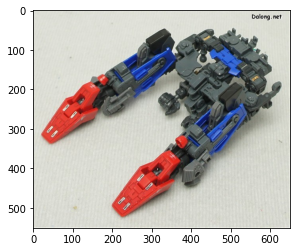

PIL Image


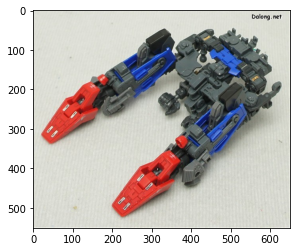

Tensor Image


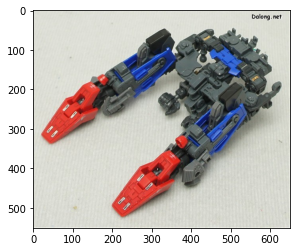

In [58]:
import PIL
from torchvision import transforms

img = data_utils.get_random_image("./data/gunpla", "*.jpg")
print ("image path")
data_utils.plot_image(img)

pil_img = PIL.Image.open(img)
print ("PIL Image")
data_utils.plot_image(pil_img)

to_tensor = transforms.Compose([
        transforms.ToTensor()
    ])
tensor_img = to_tensor(pil_img)
print ("Tensor Image")
data_utils.plot_image(tensor_img)

## Select and plot random images

In [200]:
import data_utils
img = data_utils.get_random_image("./data/gunpla", "*.jpg")
print(type(img), img)
imgs = data_utils.get_random_images("./data/gunpla", 3, "*.jpg")
print (imgs)

c = data_utils.get_image_class(img)
print (type(c), c)

<class 'pathlib.PosixPath'> data/gunpla/train/RG21/rg21_35.jpg
[PosixPath('data/gunpla/test/RG07/rg07_32.jpg'), PosixPath('data/gunpla/train/RG11/rg11_53.jpg'), PosixPath('data/gunpla/train/RG06/rg06_12.jpg')]
<class 'str'> RG21


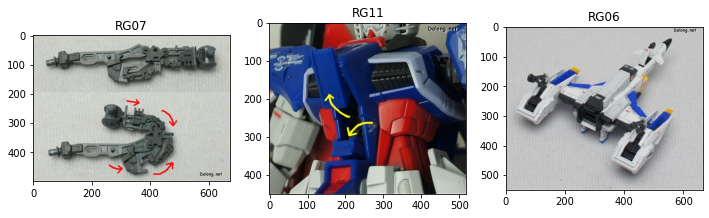

In [201]:
labels = [data_utils.get_image_class(x) for x in imgs]
data_utils.plot_images(imgs, labels)

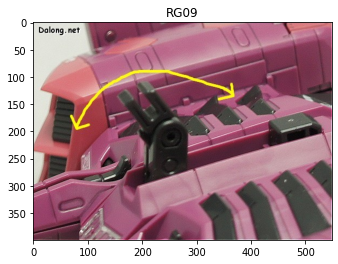

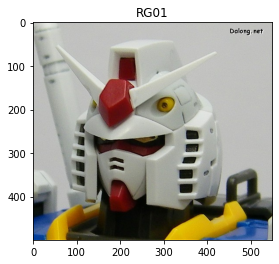

In [62]:
data_utils.show_random_image("./data/gunpla")
data_utils.show_random_image("./data/gunpla/test/RG01")

## Data distribution

# of images: 3207
	RG23                : 59
	RG12                : 98
	RG37                : 84
	RG09                : 105
	RG18                : 101
	RG14                : 67
	RG20                : 63
	RG05                : 84
	RG03                : 126
	RG29                : 96
	RG36                : 103
	RG30                : 78
	RG22                : 92
	RG15                : 88
	RG01                : 155
	RG04                : 58
	RG19                : 83
	RG27                : 72
	RG32                : 83
	RG02                : 94
	RG33                : 95
	RG25                : 102
	RG10                : 143
	RG17                : 75
	RG13                : 65
	RG28                : 75
	RG21                : 69
	RG06                : 125
	RG24                : 61
	RG35                : 80
	RG07                : 108
	RG08                : 50
	RG34                : 104
	RG26                : 44
	RG16                : 72
	RG11                : 79
	RG31                : 71
Avg  tenso

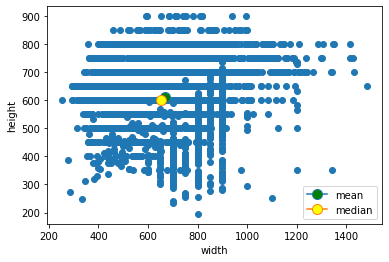

In [65]:
data_utils.show_image_statistics("./data/gunpla/", "*.jpg")

From the result above, we can find that the image vary in size, which make it difficult for training, as most model take a square input (image's width equals to height).

Instead of stretching images, in genearl is better to pad them, here comes the `SquarePad` class:

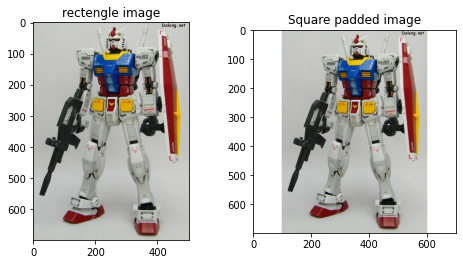

In [68]:
rect_img = PIL.Image.open("./data/playground/rg01_02.jpg")

squared_padded = data_utils.SquarePad(fill=255)(rect_img)

data_utils.plot_images([rect_img, squared_padded], ["rectengle image", "Square padded image"])

# Creating the Pytorch datasets and dataloaders

In [206]:
%%writefile dataset.py
import os
import torch
import PIL
import json

from typing import List, Optional, Tuple

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torchvision.transforms.functional as F


NUM_WORKERS = os.cpu_count()

DEFAULT_TRAIN_DIR="./data/gunpla/train"
DEFAULT_TEST_DIR="./data/gunpla/test"
DEFAULT_VALIDATE_DIR="./data/gunpla/validate"
DEFAULT_METADATA="./data/gunpla/metadata.json"

def create_dataset(
        train_dir: str = DEFAULT_TRAIN_DIR,
        test_dir: str = DEFAULT_TEST_DIR,
        validate_dir: str = DEFAULT_VALIDATE_DIR,

        train_transform: Optional[transforms.Compose] = None,
        test_transform: Optional[transforms.Compose] = None,
        validate_transform: Optional[transforms.Compose] = None,
    
        metadata: str = DEFAULT_METADATA,

    ) -> Tuple[datasets.ImageFolder, datasets.ImageFolder, datasets.ImageFolder, List[str]]:
    """Creates training and testing dataset.
    
    Takes in a training directory and testing directory path and turns
    them into PyTorch Datasets
    
    Args:
      train_dir: Path to training directory.
      test_dir: Path to testing directory.
      train_transform: optional torchvision transforms to perform on training data.
      test_transform: optional torchvision transforms to perform on testing data.

    
    Returns:
      A tuple of (train_dataset, test_dataset, class_names).
      Where class_names is a list of the target classes.
    """
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=test_transform)
    validate_data = datasets.ImageFolder(validate_dir, transform=validate_transform)

    
    class_names = train_data.classes
    
    with open(metadata) as f:
        meta = json.load(f)
        
    items=[]
    for x in class_names:
        m=meta[x]
        item=x
        code,name = m["code"], m["name"]
        if code:
            item += f" {code}"
        if name:
            item += f" {name}"
            
        items.append(item)
        
    return train_data, test_data, validate_data, items

def create_dataloaders(
        train_dir: str = DEFAULT_TRAIN_DIR,
        test_dir: str = DEFAULT_TEST_DIR,
        validate_dir: str = DEFAULT_VALIDATE_DIR,

        train_transform: Optional[transforms.Compose] = None,
        test_transform: Optional[transforms.Compose] = None,
        validate_transform: Optional[transforms.Compose] = None,
        batch_size: Optional[int]=32,
        num_workers: Optional[int]=NUM_WORKERS,
        metadata: str=DEFAULT_METADATA,
) -> Tuple[DataLoader, DataLoader, DataLoader, List[str]]:

    """Creates training and testing dataloader.
    
    Takes in a training directory and testing directory path and turns
    them into PyTorch DataloLoader
    
    Args:
      train_dir: Path to training directory.
      test_dir: Path to testing directory.
      train_transform: optional torchvision transforms to perform on training data.
      test_transform: optional torchvision transforms to perform on testing data.

    
    Returns:
      A tuple of (train_dataloader, test_dataloader, class_names).
      Where class_names is a list of the target classes.
    """
    
    train_data, test_data, validate_data, class_names = create_dataset(train_dir, test_dir, validate_dir, train_transform, test_transform, validate_transform)
    
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    validate_dataloader = DataLoader(
        validate_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    return train_dataloader, test_dataloader, validate_dataloader, class_names

class SquarePad(torch.nn.Module):
    """
    Taken from https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850/10
    With modification
    """
    def __init__(self, fill: int=0):
        super().__init__()
        self.fill = fill
        
    def __call__(self, image: PIL.Image.Image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return F.pad(image, padding, fill=self.fill, padding_mode='constant')

Overwriting dataset.py


## Creating DataLoaders

In [182]:
!rm -rf ./data/gunpla/train/.ipynb_checkpoints
!rm -rf ./data/gunpla/test/.ipynb_checkpoints
!rm -rf ./data/gunpla/validate/.ipynb_checkpoints

In [207]:
import importlib
importlib.reload(dataset)

<module 'dataset' from '/workspace/dataset.py'>

In [208]:
import dataset
train_dataloader, test_dataloader, validate_dataloader, names = dataset.create_dataloaders()
print (names)
print(f"Total classes: {len(names)}")

['RG01 RX-78-2 Gundam', "RG02 MS-06S Char's Zaku II", 'RG03 GAT-X-105 Aile Strike Gundam', 'RG04 MS-06F Zaku II', 'RG05 ZGMF-X10A Freedom Gundam', 'RG06 FX-550 Sky Grasper', 'RG07 RX-178 Gundam Mk-II Titans', 'RG08 RX-178 Gundam Mk-II A.E.U.G.', 'RG09 ZGMF-X09A Justice Gundam', 'RG10 MSZ-006 Zeta Gundam', 'RG11 ZGMF-X42S Destiny Gundam', 'RG12 RX-78GP01 Zephyranthes', 'RG13 RX-78GP01fb Full Burnern', 'RG14 ZGMF-X20A Strike Freedom Gundam', 'RG15 GN-001 Gundam Exia', "RG16 MSM-07S Char's Z'gok", 'RG17 XXXG-00W0 Wing Gundam Zero EW', 'RG18 GN-0000-GNR-010 OO Raiser', 'RG19 MBF-P02 Gundam Astray Red Frame', 'RG20 XXXG-01W Wing Gundam EW', 'RG21 GNT-0000 OO Qan[T]', 'RG22 MSN-06S Sinanju', 'RG23 Build Strike Gundam Full Package', 'RG24 Gundam Astray Gold Frame Amatsu Mina', 'RG25 RX-0 Unicorn Gundam', "RG26 MS-06R-2 Johnny Ridden's Zaku II", 'RG27 RX-0[N] Unicorn Gundam 02 Banshee Norn', 'RG28 OZ-00MS Tallgeese EW', 'RG29 MSN-04 Sazabi', 'RG30 RX-0 Full Armor Unicorn Gundam', 'RG31 XM-X1 C

## Explore the dataloader

In [209]:
print ("Training set: ", train_dataloader.dataset)
print ("Test set: ", test_dataloader.dataset)
print ("Validate set: ", validate_dataloader.dataset)

Training set:  Dataset ImageFolder
    Number of datapoints: 2263
    Root location: ./data/gunpla/train
Test set:  Dataset ImageFolder
    Number of datapoints: 944
    Root location: ./data/gunpla/test
Validate set:  Dataset ImageFolder
    Number of datapoints: 561
    Root location: ./data/gunpla/validate


## Data Transform

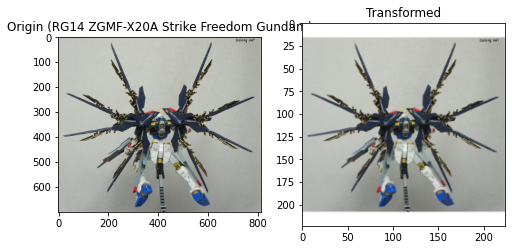

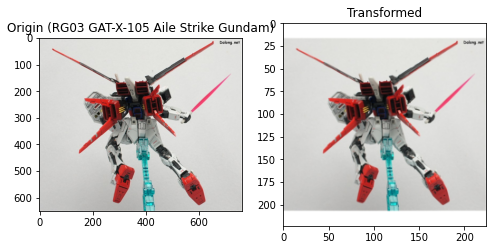

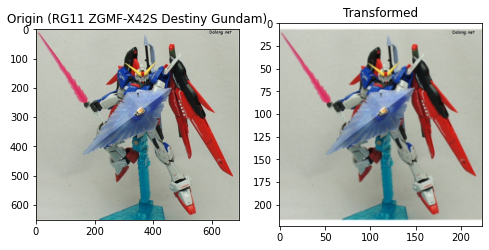

In [212]:
selected = random.choices(train_dataloader.dataset, k=3)

test_transform1 = transforms.Compose([
    dataset.SquarePad(fill=255),
    transforms.Resize((224,224)),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


trans_count=1
for x, class_id in selected:
    
    images = [x, test_transform1 (x)]
    titles = [f"Origin ({names[class_id]})", "Transformed"]
    
    data_utils.plot_images(images, titles)


Now let's convert them to tensor and add Normalization as required by many models

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


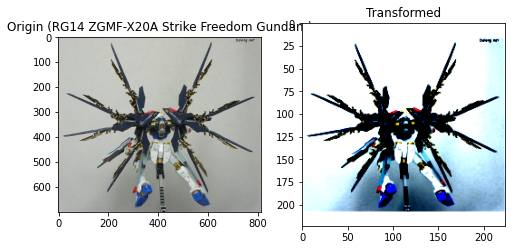

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


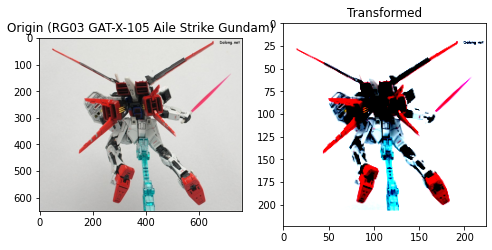

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


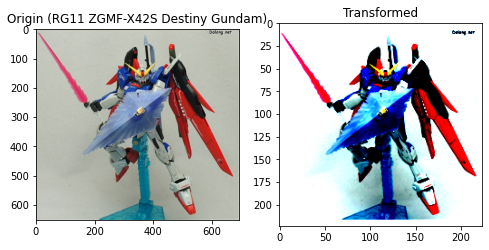

In [215]:
test_transform2 = transforms.Compose([
    dataset.SquarePad(fill=255),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


for x, class_id in selected:
    
    images = [x, test_transform2 (x)]
    titles = [f"Origin ({names[class_id]})", "Transformed"]
    
    data_utils.plot_images(images, titles)

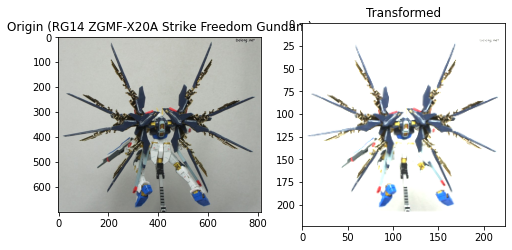

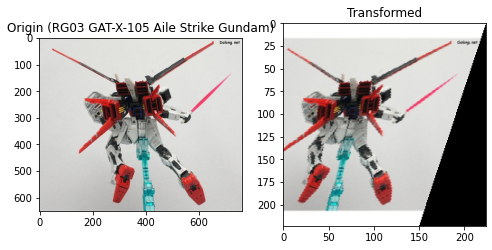

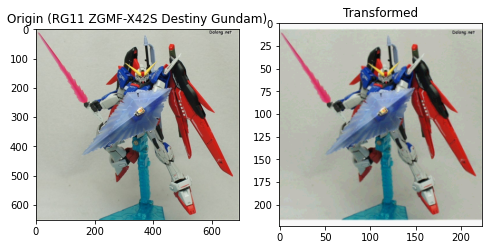

In [216]:
test_transform3 = transforms.Compose([
    dataset.SquarePad(fill=255),
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
])


for x, class_id in selected:
    
    images = [x, test_transform3 (x)]
    titles = [f"Origin ({names[class_id]})", "Transformed"]
    
    data_utils.plot_images(images, titles)